In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw
from deep_im import LossAddS
import copy
#from deep_im import flow_to_trafo
from visu import Visualizer
import matplotlib.pyplot as plt
import k3d
#exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'

env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_evaluate_pose_estimation.yml'
h = 480
w = 640
import k3d

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

batch = dataset_train[13450][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render,h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask,  bb , depth_render_original= batch[24:]



                

/home/jonfrey/PLR3/src/helper/bounding_box.py:203: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()
/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [2]:
# Evaluate Ray Tracering 
# DepthMap -> Reproject 

In [3]:
# Plotting Helper Functions (not needed)
class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
        
    def disp_img_1d(self,img,hold=False, save=False, nr=0 , ret=False):
        self.data.append(img)
        p = '/home/jonfrey/Debug/Midterm2/'
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Reds' )
                try:
                    if a.shape[2] != 3:
                        fig.colorbar(pos, ax=ax[-1])
                except:
                    pass
            plt.show()
            if save:
                fig.savefig(p+str(nr)+'.png', dpi=300)
                
            if ret: 
                if isinstance( self.data[0], torch.Tensor):
                    self.data[0] = self.data[0].numpy()
                    print('CONV')
                    
                print(self.data[0].shape)
                a = np.max(self.data[0])
                b = np.min(self.data[0])
                
                d = (self.data[0]-float(b))
                d = (d / ((float(a)-float(b))) )*255 
                d = np.uint8(d)
                img = Image.fromarray( d )
                return d
            self.data = []
            self.ax = []
            
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]

def disp_alignment(depth, label, real):
    data = np.zeros((480,640,4), dtype=np.uint8)
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    t = real
    data[:,:,:3] = t.numpy() # red patch in upper left
    data_depth[:,:,:3] = t.numpy()
    data[:,:,3] = 70
    data[:,:,3][label==8] = 255
    
    min_val = torch.min( depth[depth!=0] )
    max_val = torch.max( depth[depth!=0] )
    val = torch.clamp( ((depth-min_val) // (max_val-min_val))*255, 0, 255)
    
    img = Image.fromarray(data, 'RGBA')
    display(img)

def plot_mask(mask):
    min_val = torch.min( mask )
    max_val = float( max(1,torch.max( mask )) )
    mask = torch.clamp( (mask-min_val) / (max_val-min_val)*255 ,0,255)
    
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    data_depth[:,:,3] = 255
    for i in range(480):
        for j in range(640):
            data_depth[i,j,:4] = np.array( cmaplist[ int(mask[i,j])] )*255
    data_depth[:,:,3] = 255
    data_depth[:,:,3][label==2] = 255
    img_depth = Image.fromarray(data_depth, 'RGBA')
    display(img_depth)

def plot_two_pcd_line(x, y, point_size=0.005, c1='g', c2='r'):
    if c1 == 'b':
        k = 245
    elif c1 == 'g':
        k = 25811000
    elif c1 == 'r':
        k = 11801000
    elif c1 == 'black':
        k = 2580
    else:
        k = 2580

    if c2 == 'b':
        k2 = 245
    elif c2 == 'g':
        k2 = 25811000
    elif c2 == 'r':
        k2 = 11801000
    elif c2 == 'black':
        k2 = 2580
    else:
        k2 = 2580

    col1 = np.ones(x.shape[0]) * k
    col2 = np.ones(y.shape[0]) * k2
    plot = k3d.plot(name='points')
    plt_points = k3d.points(x, col1.astype(np.uint32), point_size=point_size)
    plot += plt_points
    plt_points = k3d.points(y, col2.astype(np.uint32), point_size=point_size)
    plot += plt_points
    for i in range(min(100,x.shape[0]) ):
        plot += k3d.line([x[i],y[i]],shader='mesh', width=0.0005, color=0xff0000)
    
    plt_points.shader = '3d'
    plot.display()

def plot_hist(x,n_bins = 20):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    colors = ['lime']
    axs.hist(x, bins=n_bins, color=colors, label=colors)
    fig.show()
    return fig

In [84]:
# Helper functions 
def get_scale_for_erosion(ero_in):
    res = torch.sum ( ero_in, dim = (2,3))
    res[res < 5000] = 5
    res[res < 10000] = 10
    res[res < 30000] = 20
    res[res < 40000] = 25
    res[res < 50000] = 30
    res[res >= 50000] = 40
    return res

def eroision(t,size=3):
    "t: tensor shape BS, C, H,W"
    out_c = t.shape[1]
    kernel_tensor = torch.ones( (out_c,1,size,size) )
    print(size, kernel_tensor, t.shape)
    return torch.nn.functional.conv2d(t, kernel_tensor, padding=(int((size)/2), int((size)/2))) == (size*size)

def smooth(t,size=3):
    "t: tensor shape BS, C, H,W"
    BS,C,H,W = t.shape
    if size == 0:
        return t
    out_c = t.shape[1]
    kernel_tensor = torch.ones( (out_c,1,size,size) ) / (size*size)
    return torch.nn.functional.conv2d(t, kernel_tensor, padding=(int((size)/2), int((size)/2)))[:BS,:C,:H,:W]



def eroision_batch(t,t_size):
    "t: tensor shape BS, C, H,W"
    "t_size: tensor shape BS"
    out_c = t.shape[1]
    for b in range( t.shape[0] ):
        size = int( t_size[b] )
        kernel_tensor = torch.ones( (out_c,1,size,size) )
        t[b] = (torch.nn.functional.conv2d(t[b][None], kernel_tensor, padding=(int((size)/2), int((size)/2))) == (size*size))[0,:,:t.shape[2], :t.shape[3]]
    return t



In [5]:
# How to load a specific datapoint form the dataset (Not Needed)

# [('data/0003/001742',), tensor([8], dtype=torch.int32)]

desig = unique_desig[0]
desig = 'data/0003/001742'

_p_ycb = "/media/scratch1/jonfrey/datasets/YCB_Video_Dataset"
depth = np.array(Image.open(
    '{0}/{1}-depth.png'.format(_p_ycb, desig)))
depth.shape

label = np.array(Image.open(
    '{0}/{1}-label.png'.format(_p_ycb, desig)))
img = np.array(Image.open(
    '{0}/{1}-color.png'.format(_p_ycb, desig)))
batch = dataset_train._backend.getElement( desig, 8)
batch = batch #bann 10450   
model_points = batch[4]
idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
real_img_original = batch[8]
cam = batch[9]
real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask, bb, render_orig = batch[24:]


In [6]:
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]
import time

In [7]:
# set loader to BS 1
exp['loader']['batch_size'] = 1
exp['loader']['pin_memory'] = False
exp['loader']['shuffle'] = True
exp['loader']['num_workers'] = 1

exp['d_train']["output_cfg"]['overfitting_nr_idx'] = -1
exp['d_train']["flow_cfg"]['sub'] = 1
exp['d_train']["flow_cfg"]['min_matches'] = 50
exp['d_train']["flow_cfg"]['max_matches'] = 5000
exp['d_train']["flow_cfg"]['max_iterations'] = 20000
exp['d_train']["flow_cfg"]['dil_kernel_size'] = 3

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)


# get test and train dataset
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                                       **exp['loader'])
exp['d_test']["output_cfg"]['overfitting_nr_idx'] = -1
exp['d_test']["output_cfg"]['noise_translation'] = 0.025
exp['d_test']["output_cfg"]['noise_rotation'] = 25

exp['d_test']["flow_cfg"]['sub'] = 2
exp['d_test']["flow_cfg"]['min_matches'] = 300
exp['d_test']["flow_cfg"]['max_matches'] = 5000
exp['d_test']["flow_cfg"]['max_iterations'] = 10000
exp['d_test']["flow_cfg"]['dil_kernel_size'] = 1
dataset_test = GenericDataset(
    cfg_d=exp['d_test'],
    cfg_env=env)
dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                                       **exp['loader'])

# get Loss function
criterion_adds = LossAddS(sym_list=exp['d_train']['obj_list_sym'])





In [8]:
idxmax = -1 
def get_H(pcd):
    pcd_ret = torch.ones( (pcd.shape[0],pcd.shape[1]+1),device=pcd.device, dtype=pcd.dtype )
    pcd_ret[:,:3] = pcd
    return pcd_ret

def eval_T(P_real_in_center, P_ren_in_center, T_res):
        """
        NR,3
        NR,3 
        4,4
        """
        P_ren_H = get_H( P_ren_in_center )
        P_ren_trafo =  (P_ren_H @ T_res.T)[:,:3]
        L2_dis_post = torch.mean( torch.norm( P_real_in_center-P_ren_trafo, dim=1 ) )
        L2_dis_pre = torch.mean( torch.norm( P_real_in_center-P_ren_in_center, dim=1 ) )
        return L2_dis_post, L2_dis_pre  

In [9]:
import torch
import numpy as np
import copy
from helper import anal_tensor

def solve_transform(keypoints, gt_keypoints):
    """
    keypoints: N x K x 3
    gt_keypoints: K x 3
    return: N x 4 x 4 transformation matrix
    """
    try:
        keypoints = keypoints.clone()
        gt_keypoints = gt_keypoints.clone()
        N, K, _ = keypoints.shape
        center = keypoints.mean(dim=1)
        gt_center = gt_keypoints.mean(dim=0)
        keypoints -= center[:, None, :]
        gt_keypoints -= gt_center[None]
        matrix = keypoints.transpose(2, 1) @ gt_keypoints[None]
        U, S, V = torch.svd(matrix)
        
        Vt = V.transpose(2, 1)
        Ut = U.transpose(2, 1)

        d = (V @ Ut).det()
        I = torch.eye(3, 3, dtype=gt_center.dtype, device= keypoints.device)[None].repeat(N, 1, 1)
        I[:, 2, 2] = d.clone()

        R = U @ I @ Vt
        T = torch.zeros(N, 4, 4, dtype=gt_center.dtype, device= keypoints.device)
        T[:, 0:3, 0:3] = R
        T[:, 0:3, 3] = center[None] - (R @ gt_center[None :, None])[:, :, 0]
        T[:, 3, 3] = 1.0

        return T
    except RuntimeError as error:
        import ipdb; ipdb.set_trace()
        print("Something went wrong")

# costume implementation 
def solve_transform2(A,B):
    if A.shape[0] > B.shape[0]:
        x=torch.arange(A.shape[0],device=A.device)
        out = torch.randperm(x.numel(),device=A.device)[:B.shape[0]]
        A = torch.index_select(A, 0, out)
    if A.shape[0] < B.shape[0]:
        x=torch.arange(B.shape[0],device=A.device)
        out = torch.randperm(x.numel(),device=A.device)[:A.shape[0]]
        B = torch.index_select(B, 0, out)

    #A = torch.choice(A,B.shape[0])

    assert A.shape == B.shape

    m = A.shape[1]
    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)

    AA = (A - centroid_A)
    BB = (B - centroid_B)
    H = AA.transpose(0,1) @ BB
    U, S, Vt = torch.svd(H)
    R = Vt @ U.transpose(0,1)
    if torch.det(R) < 0:
        Vt[m-1,:] *= -1
        R = Vt.transpose(0,1) @ U.transpose(0,1)

    # translation
    t = centroid_B - (R @ centroid_A)
    # homogeneous transformation
    T = torch.eye(m+1, device= A.device)
    T[:m, :m] = R
    T[:m, m] = t
    return T


# NR = 1000
# DIM = 3
# A = torch.ones( (NR,DIM), dtype= torch.float32)
# B = A*1.7223
# T = solve_transform2(A,B)
# print(T)


# A_hom = get_H(A)
# A_hom2 = A_hom @ T.T
# print(A_hom2[:,:3])

def filter_pcd_given_depthmap(pcd, depth, scal= 10000):
    """
    pcd = Nx3 troch.float32
    depth = N torch.float32

    return N torch.bool
    """
    m1 = (depth/scal) > 0.01
    #print( "Thorwn away values", (depth/scal) < 0.2 )
    return m1

    val_d = depth[ m1 ]
    mean = torch.mean(val_d)
    new_d = depth - mean
    tol = 0.5
    m2 = torch.abs( new_d/scal ) < tol 
    return m1 * m2
    
def filter_pcd( pcd, tol = 0.6):
    """
    input:
        pcd : Nx3 torch.float32
    returns:
        mask : NX3 torch.bool 
    """
    return pcd[:,2] > 0.05
    
    m = torch.mean(pcd, dim = 0)
    comp = m[None,:].repeat(pcd.shape[0],1) + tol
    mean_free = pcd-m[None,:].repeat(comp.shape[0],1)
    mask = torch.norm( mean_free,  dim= 1) > tol
    #print(f"filter_pcd PRE: {pcd.shape}, POST: {float(torch.sum(mask[:,None].repeat(1,3) == False ))/3.0}")
    return mask == False

def filter_pcd_cor(pcd1, pcd2, max_mean_deviation=0.2):
    
    dif = torch.norm( pcd1-pcd2 , dim= 1)
    mean = torch.mean(dif, dim = 0)
    mean_free = torch.abs(dif-mean)
    #print(f"filter_pcd_cor PRE: {pcd1.shape[0]}, POST: {torch.sum(mean_free < max_mean_deviation)}")
    return mean_free < max_mean_deviation
    
def flow_to_trafo(*args, **kwargs):
    """
    input:
      real_br: torch.tensor torch.Size([2])
      real_tl: torch.tensor torch.Size([2])
      ren_br: torch.tensor torch.Size([2])
      ren_tl: torch.tensor torch.Size([2])
      flow_mask: torch.Size([480, 640])
      u_map: torch.Size([480, 640])
      v_map: torch.Size([480, 640])
      K_real: torch.Size([3, 3])
      K_ren: torch.Size([3, 3])
      real_d: torch.Size([480, 640]) 
      render_d: torch.Size([480, 640])
      h_real: torch.Size([4, 4])
      h_render: torch.Size([4, 4])
    output:
      P_real_in_center: torch.Size([N, 3])
      P_ren_in_center: torch.Size([N, 3]) 
      P_real_trafo: torch.Size([N, 3])
      T_res: torch.Size([4, 4])
      
      The output rotation T_res is defined in the Camera coordinate frame. 
      Therfore premultiply the T_Res with h_render to get the new h_real_new !!!
    """
    for k in kwargs.keys():
        pass
        #print(f"Variable: {k}, Type {type(kwargs[k])}, Dtype{kwargs[k].dtype}, Shape{kwargs[k].shape}")
    real_br = kwargs['real_br']
    real_tl = kwargs['real_tl']
    ren_br = kwargs['ren_br']
    ren_tl = kwargs['ren_tl']
    flow_mask = kwargs['flow_mask']
    u_map = kwargs['u_map']
    v_map = kwargs['v_map']
    K_real = kwargs['K_real']
    K_ren = kwargs['K_ren']
    real_d = kwargs['real_d']
    render_d = kwargs['render_d']
    h_real = kwargs['h_real']
    h_render = kwargs['h_render']
    plot_pcd = kwargs.get('plot_pcd',False)
  
    # Grid for upsampled real
    grid_real_h = torch.linspace(int(real_tl[0]) ,int(real_br[0]) , 480, device=u_map.device)[:,None].repeat(1,640)
    grid_real_w = torch.linspace(int(real_tl[1]) ,int(real_br[1]) , 640, device=u_map.device)[None,:].repeat(480,1)


    # Grid for upsampled ren
    c = 0
    
    grid_ren_h = torch.linspace(int(ren_tl[0]) ,int(ren_br[0]) , 480, device=u_map.device)[:,None].repeat(1,640)
    grid_ren_w = torch.linspace(int(ren_tl[1]) ,int(ren_br[1]) , 640, device=u_map.device)[None,:].repeat(480,1)
    # Calculate valid depth map for rendered image
    render_d_ind_h = torch.linspace(0 ,479 , 480, device=u_map.device)[:,None].repeat(1,640)
    render_d_ind_w= torch.linspace(0 ,639 , 640, device=u_map.device)[None,:].repeat(480,1)

    render_d_ind_h = torch.clamp(torch.round((render_d_ind_h - u_map).type(torch.float32)) ,0,479).type( torch.long )[flow_mask]
    render_d_ind_w = torch.clamp(torch.round((render_d_ind_w - v_map).type(torch.float32)),0,639).type( torch.long )[flow_mask] 
    index = render_d_ind_h*640 + render_d_ind_w # hacky indexing along two dimensions
    ren_d_masked  = render_d.flatten()[index]
    
    # Project depth map to the pointcloud real
    cam_scale = 10000

    real_pixels = torch.stack( [grid_real_w[flow_mask], grid_real_h[flow_mask], torch.ones(grid_real_h.shape, device = u_map.device,  dtype= u_map.dtype)[flow_mask]], dim=1 ).type(u_map.dtype)
    K_inv = torch.inverse(K_real.type(torch.float32)).type(u_map.dtype)
    P_real = K_inv @ real_pixels.T
    P_real = P_real * real_d[flow_mask] / cam_scale
    P_real = P_real.T
    
    # Project depth map to the pointcloud render
    K_ren_inv = torch.inverse(K_ren.type(torch.float32)).type(u_map.dtype)
    ren_pixels = torch.stack( [grid_ren_w[flow_mask] - v_map[flow_mask], 
                            grid_ren_h[flow_mask] - u_map[flow_mask],
                            torch.ones(grid_ren_h.shape, device = u_map.device,  dtype= u_map.dtype )[flow_mask]], 
                            dim=1 ).type(u_map.dtype)
    P_ren = K_ren_inv @ ren_pixels.T
    P_ren = P_ren * ren_d_masked / cam_scale
    P_ren = P_ren.T

    # Filter the pointclouds given the depthmap
#     m_ren_depth = filter_pcd_given_depthmap(P_ren, ren_d_masked)
#     m_real_depth = filter_pcd_given_depthmap(P_real, real_d[flow_mask])
#     m_total =  m_ren_depth * m_real_depth
    
    min_points = 20
#     if torch.sum(m_total) < min_points:
#         print(f'Violation filter pcd_given_depthmap: P_in: {P_ren.shape[0]} P_out: {torch.sum(m_total)}')
#         return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

#     P_ren = P_ren[m_total] 
#     P_real = P_real[m_total]
    # anal_tensor(  P_ren, 'P_ren m_total masked')

    # Do not transfrom to center coordinate system
    P_real_in_center = P_real                      
    P_ren_in_center = P_ren 
    
    m_real = filter_pcd( P_real_in_center )
    m_ren = filter_pcd( P_ren_in_center )
    m_tot = m_real * m_ren
    if torch.sum(m_tot) < min_points:
        print(f'Violation filter_pcd: P_in: { P_ren_in_center.shape[0]} P_out: {torch.sum(m_tot)}')
        return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

    P_real_in_center = P_real_in_center[m_tot]
    P_ren_in_center = P_ren_in_center[m_tot]
  
    # Max mean deviation
    m_new = filter_pcd_cor(P_real_in_center, P_ren_in_center)
    
    if torch.sum(m_new) < min_points:
        print(f'Violation filter_pcd_cor: P_in: { P_ren_in_center.shape[0]} P_out: {torch.sum(m_new)}')
        return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

    P_real_in_center = P_real_in_center[m_new]
    P_ren_in_center = P_ren_in_center[m_new]

    # random shuffel
    pts_trafo = min( P_real_in_center.shape[0], 1000 )
    idx = torch.randperm( P_real_in_center.shape[0] )[0:pts_trafo]
    P_real_in_center = P_real_in_center[idx]
    P_ren_in_center = P_ren_in_center[idx]

    T_res = solve_transform( P_real_in_center[None].type(torch.float64 ) , P_ren_in_center.type(torch.float64 ) ).type(u_map.dtype )
    
    # Transform the real points according to calculated transformation
    P_hr = torch.ones( (P_real_in_center.shape[0],4 ) , device=u_map.device, dtype= u_map.dtype)
    P_hr[:,:3] = P_real_in_center
    P_real_trafo = (torch.inverse( T_res[0].type(torch.float32) ).type(u_map.dtype ) @ copy.deepcopy(P_hr).T).T [:,:3]

    return True, P_real_in_center, P_ren_in_center, P_real_trafo, T_res[0]



In [10]:
import cv2 
cv2.__version__
from scipy.spatial.transform import Rotation as R
import k3d 
def rvec_tvec_to_H(r_vec,t_vec):
    # get homogenous output transformation
    rot = R.from_rotvec(r_vec)
    h = np.eye(4)
    h[:3,:3] = rot.as_matrix()
    h[:3,3] = t_vec.T
#     print(h)
    return h
class SingleObjectADDLoss:
    def asymmetric(self, gt_T, T_hat, model_points):
        R_hat = T_hat[:3, :3]
        t_hat = T_hat[:3, 3, None]
        model_points = model_points[:, :, None]
        predicted = ((R_hat @ model_points) + t_hat)[:, :, 0]
        R_gt = gt_T[:3, :3]
        t_gt = gt_T[:3, 3, None]
        ground_truth = ((R_gt @ model_points) + t_gt)[:, :, 0]
        return (ground_truth - predicted).norm(dim=1).mean()

    def symmetric(self, gt_T, T_hat, model_points):
        ones = torch.ones(
            model_points.shape[0], 1, dtype=model_points.dtype).to(gt_T.device)
        points = torch.cat([model_points, ones], dim=1)[:, :, None]
        ground_truth = (gt_T @ points)[:, :3, 0]
        predicted = (T_hat @ points)[:, :3, 0]
        dima = (ground_truth[None] - predicted[:, None]).norm(dim=2)
        min_values, _ = dima.min(dim=1)
        return min_values.mean(dim=0)
    
    def pcd(self, ground_truth, predicted):
        dima = (ground_truth[None] - predicted[:, None]).norm(dim=2)
        min_values, _ = dima.min(dim=1)
        return min_values.mean(dim=0)

In [11]:
full_time_in_ransac_ls = [0]

def flow_to_trafo_PnP_jup(*args, **kwargs):
    real_br = kwargs['real_br']
    real_tl = kwargs['real_tl']
    ren_br = kwargs['ren_br']
    ren_tl = kwargs['ren_tl']
    flow_mask = kwargs['flow_mask']
    u_map = kwargs['u_map']
    v_map = kwargs['v_map']
    K_real = kwargs['K_real']
    K_ren = kwargs['K_ren']
    real_d = kwargs['real_d']
    render_d = kwargs['render_d']
    h_real = kwargs['h_real']
    h_render = kwargs['h_render']
    h_real_est = kwargs['h_real_est']
    mp = kwargs['mp']
    img = kwargs['img']
    mode = kwargs.get('mode','refine')
    full_time_in_ransac_ls = kwargs.get('full_time_in_ransac_ls',[0] )
    typ = u_map.dtype

    # Grid for upsampled real
    grid_real_h = torch.linspace(int(real_tl[0]) ,int(real_br[0]) , 480, device=u_map.device)[:,None].repeat(1,640)
    grid_real_w = torch.linspace(int(real_tl[1]) ,int(real_br[1]) , 640, device=u_map.device)[None,:].repeat(480,1)
    # Project depth map to the pointcloud real
    cam_scale = 10000
    real_pixels = torch.stack( [grid_real_w[flow_mask], grid_real_h[flow_mask], torch.ones(grid_real_h.shape, device = u_map.device,  dtype= u_map.dtype)[flow_mask]], dim=1 ).type(typ)
    K_inv = torch.inverse(K_real.type(torch.float64)).type(typ)
    P_real = K_inv @ real_pixels.T
    P_real = P_real.type(torch.float64) * real_d[flow_mask] / cam_scale
    P_real = P_real.T

    
    grid_ren_h = torch.linspace(int(ren_tl[0]) ,int(ren_br[0]), 480, device=u_map.device)[:,None].repeat(1,640)
    grid_ren_w = torch.linspace(int(ren_tl[1]) ,int(ren_br[1]) , 640, device=u_map.device)[None,:].repeat(480,1)
    crop_d_pixels = torch.stack( [grid_ren_w.flatten(), grid_ren_h.flatten(), torch.ones(grid_ren_w.shape, device = u_map.device,  dtype= torch.float64).flatten()], dim=1 ).type(typ)
    K_inv = torch.inverse(K_ren.type(torch.float64)).type(typ)
    P_crop_d = K_inv @ crop_d_pixels.T.type(typ)
    P_crop_d = P_crop_d.type(torch.float64) * render_d.flatten() / cam_scale
    P_crop_d = P_crop_d.T


    render_d_ind_h = torch.linspace(0 ,479 , 480, device=u_map.device)[:,None].repeat(1,640)
    render_d_ind_w= torch.linspace(0 ,639 , 640, device=u_map.device)[None,:].repeat(480,1)
    render_d_ind_h = torch.clamp((render_d_ind_h - u_map).type(torch.float64) ,0,479).type( torch.long )[flow_mask]
    render_d_ind_w = torch.clamp((render_d_ind_w - v_map).type(torch.float32),0,639).type( torch.long )[flow_mask] 
    index = render_d_ind_h*640 + render_d_ind_w # hacky indexing along two dimensions

    P_crop_d  = P_crop_d[index] 
    crop_d_pixels = crop_d_pixels[index] 


    m = filter_pcd( P_crop_d)
    P_crop_d  = P_crop_d[ m ]
    P_real = P_real[m]
    real_pixels = real_pixels[m]
    P_ren = P_crop_d

    # random shuffel
    pts_trafo = min(P_real.shape[0], 50000)
    idx = torch.randperm( P_real.shape[0] )[0:pts_trafo]
    P_real = P_real[idx]
    P_ren = P_ren[idx]
    real_pixels = real_pixels[idx]

    nr = 10000
    mp_render = get_H(mp)
    mp_render = (mp_render.type(typ)@ h_render.type(typ).T)[::5,:3]
    mp_real = get_H(mp)
    mp_real = (mp_real.type(typ) @ h_real.type(typ).T)[::5,:3]

#    

    P_ren_in_origin =  (get_H( P_ren ).type(typ) @ torch.inverse( h_render.type(torch.float64) ).type(typ).T) [:,:3]

    # PNP estimation
    objectPoints = P_ren_in_origin.clone().numpy()    
    imagePoints = real_pixels[:,:2].numpy()
    dist = np.array( [[0.0,0.0,0.0,0.0]] )

    if objectPoints.shape[0] < 8:
#         visualizer.plot_estimated_pose_on_bb( tag = f"_",
#             epoch = 1,
#             img= render_img[0].numpy()  ,
#             tl = ren_tl,
#             br = ren_br,
#             points = P_ren[:nr,:3],
#             store = False,
#             jupyter= True,
#             K = K_ren.cpu().numpy(),
#             H = np.eye(4),
#             method='def')

#         plot_two_pcd(mp_render.numpy(), P_ren[:nr,:3].numpy())

#         #inp = render_img[0].clone()
#         inp = render_img_original[0].clone()
#         inp = real_img_original[0].clone()
#         for j in range(0,nr):
#             try:

#                 v = int(real_pixels[j,0])
#                 u = int(real_pixels[j,1])
#                 inp[u:u+4,v:v+4,: ] = torch.tensor( [255,0,255])
#             except:
#                 pass
#         display( Image.fromarray( np.uint8(inp.numpy())) )
        
        print(f'Failed due to missing corsspondences,{ objectPoints.shape[0]}, Filtering given depth: {m.shape}, index {index.shape}')
        return False, torch.eye(4, dtype= u_map.dtype, device=u_map.device )
    # set current guess as the inital estimate

    rvec = R.from_matrix(h_real_est[:3,:3]).as_rotvec().astype(np.float32)
    tvec = h_real_est[:3,3].numpy().astype(np.float32)
    # calculate PnP between the pixels coordinates in the real image and the corrosponding points in the origin frame
    start = time.time()
    if mode == "refine":
        r_vec2, t_vec2 = cv2.solvePnPRefineLM(copy.deepcopy(objectPoints), \
            copy.deepcopy(imagePoints), 
            K_real.numpy(), 
            dist, 
            copy.deepcopy(rvec),
            copy.deepcopy( tvec))
        r_vec2 = r_vec2[:,None]
    elif mode == "iterative1000" :
        retval, r_vec2, t_vec2, inliers = cv2.solvePnPRansac(copy.deepcopy(objectPoints), \
            copy.deepcopy(imagePoints), 
            K_real.numpy(), 
            dist, 
            iterationsCount = 1000, 
            reprojectionError= 0.3,
            flags= cv2.SOLVEPNP_ITERATIVE)
        
    elif mode == "iterative100" :
        retval, r_vec2, t_vec2, inliers = cv2.solvePnPRansac(copy.deepcopy(objectPoints), \
            copy.deepcopy(imagePoints), 
            K_real.numpy(), 
            dist, 
            iterationsCount = 100, 
            reprojectionError= 0.3,
            flags= cv2.SOLVEPNP_ITERATIVE)
        
    elif mode == "iterative100reER1":
        retval, r_vec2, t_vec2, inliers = cv2.solvePnPRansac(copy.deepcopy(objectPoints), \
            copy.deepcopy(imagePoints), 
            K_real.numpy(), 
            dist, 
            iterationsCount = 1000, 
            reprojectionError= 1,
            flags= cv2.SOLVEPNP_ITERATIVE)
        r_vec2 = r_vec2[:,None]
    
    elif mode == "SOLVEPNP_EPNP":
        retval, r_vec2, t_vec2, inliers = cv2.solvePnPRansac(copy.deepcopy(objectPoints), \
            copy.deepcopy(imagePoints), 
            K_real.numpy(), 
            dist, 
            iterationsCount = 1000, 
            reprojectionError= 0.3,
            flags= cv2.SOLVEPNP_EPNP)
        
        
    full_time_in_ransac_ls[0] = full_time_in_ransac_ls[0] + time.time()-start
    h = rvec_tvec_to_H(r_vec2[:,0],t_vec2)
    return True,torch.from_numpy( h).type(u_map.dtype) 

if False:
    h = flow_to_trafo_PnP(real_br = real_br[b].clone(),
        real_tl = (real_tl[b]).clone() ,
        ren_br = (ren_br[b]).clone(),
        ren_tl = (ren_tl[b]).clone(),
        flow_mask = (flow_mask[b]).clone(),
        u_map = (u_map[b].type( typ )).clone(),
        v_map = (v_map[b].type( typ )).clone(), 
        K_real = (K_real.type( typ )).clone(),
        K_ren = (K_ren.type( typ )).clone(),
        real_d = (real_d[b].type( typ )).clone(),
        render_d = (render_d[b].type( typ )).clone(),
        h_real = (h_real[b].type(typ )).clone(),
        h_render = (h_render[b].type( typ )).clone(),
        h_real_est = h_real_est,
        mp = model_points[0],
        img = real_img_original[0].clone() )
print('Done')

Done


In [12]:
len(dataloader_test)

14025

In [13]:
from visu import plot_two_pcd
import pandas as pd

device = 'cpu'

visualizer = Visualizer('/home/jonfrey/Debug', None)

K_ren = torch.tensor( dataset_train._backend.get_camera('data_syn/0019', K=True), device=device ) 
K_ren = torch.tensor( dataset_train._backend.get_camera('data/0049', K=True), device=device ) 
modes = ['refine',"iterative1000","iterative100", "iterative100reER1","SOLVEPNP_EPNP"]
max_iter = 10
names = ['ID','ADD-S GT','ADD-S INITAL','ADD-S Random', 'ADD-S Bias']
df = pd.DataFrame(columns=names)
df_failed = pd.DataFrame(columns= ['ID'])

full_time_in_ransac_ls = [0]
for j,batch in enumerate(dataloader_test):
    
    print( full_time_in_ransac_ls, type(full_time_in_ransac_ls) )
    batch = batch[0]
    if j > max_iter-1:
        break
    if j % 10 == 0:
        print(f"Processed {j}/{max_iter}")

    b = 0    
    model_points = batch[4]
    idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
    label = batch[7]
    real_img_original = batch[8]
    cam = batch[9]
    gt_rot_wxyz, gt_trans, unique_desig = batch[10:13] # unique_desig[1] contains the idx starting at 1 for the first object 
    bs = model_points.shape[0]
    if batch[13] is False:
        print('Continue')
        continue
    real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
    pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
    u_map, v_map, flow_mask, bb, depth_render_original= batch[24:]
    real_tl, real_br, ren_tl, ren_br = bb 
    
    data = torch.cat([real_img, render_img], dim=1)
    uv_gt = torch.stack( [u_map, v_map], dim=3 ).permute(0,3,1,2)
    
    K_real = torch.tensor( [[cam[b,2],0,cam[b,0]],[b,cam[b,3],cam[b,1]],[0,0,1]], device=device )
    
    #get inital estimate of the poistion given by the dataloader
    h_real_est = torch.eye(4,device=device)
    h_real_est[:3,:3] = quat_to_rot(pred_rot_wxyz[b][None,:], conv='wxyz', device=device)
    h_real_est[:3,3] = torch.tensor( pred_trans[b].clone().detach() ,device=device )
    
    
    ### GT Estimate ###
    typ = u_map.dtype
    fmt = flow_mask.dtype
    
    suc = True
    ### GT Label PnP ###
    suc_, gt_h_est = flow_to_trafo_PnP(
        real_br = real_br[b].clone(),
        real_tl = (real_tl[b]).clone(), 
        ren_br = (ren_br[b]).clone(), 
        ren_tl = (ren_tl[b]).clone(),
        flow_mask = (flow_mask[b]).clone(), 
        u_map = (u_map[b].type( typ )).clone(),
        v_map = (v_map[b].type( typ )).clone(), 
        K_real = (K_real.type( typ )).clone(),
        K_ren = (K_ren.type( typ )).clone(),
        real_d = (real_d[b].type( typ )).clone(),
        render_d = (render_d[b].type( typ )).clone(),
        h_real = (h_real[b].type( typ )).clone(), 
        h_render = (h_render[b].type( typ )).clone(),
        h_real_est = h_real_est,
        mp = model_points[b].clone(),
        img = real_img_original[b].clone(),
        full_time_in_ransac_ls = full_time_in_ransac_ls,
        mode= modes[-1])
    suc = suc_ and suc
    
    
    ### N1 ###
    lvl = 5
    n1 = torch.rand(v_map[b].shape, dtype = typ)
    n2 = torch.rand(v_map[b].shape, dtype = typ)
    u_map_clone = (u_map[b]).type( typ ).clone() + (n1 - 0.5) * 2 * lvl
    v_map_clone = (v_map[b]).type( typ ).clone() + (n2 - 0.5) * 2 * lvl
    
    suc_, n1_h_est = flow_to_trafo_PnP(
        real_br = copy.deepcopy(real_br[b]),
        real_tl = copy.deepcopy(real_tl[b]), 
        ren_br = copy.deepcopy(ren_br[b]), 
        ren_tl = copy.deepcopy(ren_tl[b]),
        flow_mask = copy.deepcopy(flow_mask[b]), 
        u_map = u_map_clone, 
        v_map = v_map_clone, 
        K_real = copy.deepcopy(K_real.type( typ )),
        K_ren = copy.deepcopy(K_ren.type( typ )),
        real_d = copy.deepcopy(real_d[b].type( typ )),
        render_d = copy.deepcopy(render_d[b].type( typ )),
        h_real = copy.deepcopy(h_real_est.type( typ )), 
        h_render = copy.deepcopy(h_render[b].type( typ )),
        h_real_est = h_real_est.clone(),
        mp = model_points[b].clone(),
        img = real_img_original[b].clone(),
        full_time_in_ransac_ls = full_time_in_ransac_ls)
    suc = suc_ and suc
    
    
    ### N2 ###
    lvl = 5
    n1 = float(torch.rand((1), dtype = typ ))
    n2 = float(torch.rand((1), dtype = typ ))
    u_map_clone = (u_map[b]).type( typ ).clone() + float( (n1 - 0.5) * 2 * lvl )
    v_map_clone = (v_map[b]).type( typ ).clone() + float( (n2 - 0.5) * 2 * lvl )
    
    suc_, n2_h_est = flow_to_trafo_PnP(
        real_br = copy.deepcopy(real_br[b]),
        real_tl = copy.deepcopy(real_tl[b]), 
        ren_br = copy.deepcopy(ren_br[b]), 
        ren_tl = copy.deepcopy(ren_tl[b]),
        flow_mask = copy.deepcopy(flow_mask[b]), 
        u_map = u_map_clone, 
        v_map = v_map_clone, 
        K_real = copy.deepcopy(K_real.type( typ )),
        K_ren = copy.deepcopy(K_ren.type( typ )),
        real_d = copy.deepcopy(real_d[b].type( typ )),
        render_d = copy.deepcopy(render_d[b].type( typ )),
        h_real = copy.deepcopy(h_real_est.type( typ )), 
        h_render = copy.deepcopy(h_render[b].type( typ )),
        h_real_est = h_real_est.clone(),
        mp = model_points[b].clone(),
        img = real_img_original[b].clone(),
        full_time_in_ransac_ls = full_time_in_ransac_ls)
    suc = suc_ and suc
    print('FULL TIME IN ransac', full_time_in_ransac_ls[0] ,'s')
    if not suc: 
        df_failed = df_failed.append({'ID': int( unique_desig[1])}, ignore_index=True)
        continue 
        
    p = model_points.shape[1]
    target = torch.bmm( model_points, torch.transpose(h_real[:,:3,:3], 1,2 ) ) + h_real[:,:3,3][:,None,:].repeat(1,p,1)

        
    # Compute ADD-S
    adds_res_gt_flow = float(criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = gt_h_est[None].type( target.dtype)).detach())
    adds_res_n1 = float(criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = n1_h_est[None].type( target.dtype) ).detach())
    adds_res_n2 = float(criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = n2_h_est[None].type( target.dtype) ).detach())
    adds_init = float(criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = h_real_est[None].type( target.dtype)).detach())
    
    
    test_values = [int( unique_desig[1]), adds_res_gt_flow, adds_init, adds_res_n1, adds_res_n2]
    res = {names[i]: test_values[i] for i in range(len(names))} 
    df = df.append(res, ignore_index=True)
    
    print(f'Not Iteration {j} < 0.02 ADD-S, GT', adds_res_gt_flow)
    
    if adds_res_gt_flow > 0.2 :

#             break
#         continue
#         print("Real depth map cropped")
        real_depth_img = Drawer().disp_img_1d(render_d[b].numpy(),ret=True)
#        real_depth_img = Drawer().disp_img_1d(depth_render_original[0][0].numpy(),ret=True)
#         real_depth_img = np.repeat( real_depth_img[:,:,None],3, axis=2)
#         print("Render depth map cropped")
#         render_depth_img = Drawer().disp_img_1d(render_d[b].numpy(),ret=True)
#         render_depth_img = np.repeat( render_depth_img[:,:,None],3, axis=2)
#         Drawer().disp_img_1d(flow_mask[0],ret=True)

#         sub = max(1,int( P_real_in_center.shape[0]/100 ) )
#         plot_two_pcd_line(P_real_in_center[::sub].numpy(), P_ren_in_center[::sub].numpy() )
#         plot_two_pcd_line(P_real_trafo[::sub].numpy(), P_ren_in_center[::sub].numpy() )

#         print(f"Real Image, Estimated Points given GT Flow {P_real_in_center.shape}")
#         visualizer.plot_estimated_pose( tag = f"_",
#                         epoch = 1,
#                         img= real_img_original[b].cpu().numpy(),
#                         points =copy.deepcopy(model_points[0].cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = h_real[0].numpy(),
#                         method='def')
#         print("Real Image Cropped, Estimated Points given GT Flow")
#         visualizer.plot_estimated_pose_on_bb( tag = f"_",
#                         epoch = 1,
#                         img= real_depth_img,
#                         tl = real_tl[0],
#                         br = real_br[0],
#                         points = copy.deepcopy( P_real_in_center.cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = np.eye(4),
#                         method='def')

#         fil = label == unique_desig[1]    
#         real_img_original[b][ fil[0][:,:,None].repeat(1,1,3) ] = 255
#         print("Real Image, Estimated Points given GT Flow with label is white")
#         visualizer.plot_estimated_pose( tag = f"_",
#                         epoch = 1,
#                         img= real_img_original[b].cpu().numpy(),
#                         points = copy.deepcopy( P_real_in_center.cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = np.eye(4),
#                         method='def')


        
        print("GT: Render Image Cropped")
        visualizer.plot_estimated_pose_on_bb( tag = f"_",
                            epoch = 1,
                            img= render_img[0].numpy(),
                            points = copy.deepcopy(model_points[0].cpu().numpy()),
                            tl = ren_tl[0],
                            br = ren_br[0],
                            store = False,
                            jupyter=True,
                            K = K_ren.cpu().numpy(),
                            H = h_render[0].numpy(),
                            method='def')
        print("PNP, Real Image")
        visualizer.plot_estimated_pose( tag = f"_",
                            epoch = 1,
                            img= real_img_original[b].cpu().numpy(),
                            points = copy.deepcopy(model_points[0].cpu().numpy()),
                            store = False,
                            jupyter= True,
                            K = K_ren.cpu().numpy(),
                            H = pnp_h_gt.clone().numpy(),
                            method='def')
        
        print("PNP: Render Image Cropped")
        visualizer.plot_estimated_pose_on_bb( tag = f"_",
                            epoch = 1,
                            img= render_img[0].numpy(),
                            points = copy.deepcopy(model_points[0].cpu().numpy()),
                            tl = ren_tl[0],
                            br = ren_br[0],
                            store = False,
                            jupyter=True,
                            K = K_ren.cpu().numpy(),
                            H = h_render[0].clone().numpy(),
                            method='def')

#         print('Valid Flow Mask')
#         visualizer.plot_segmentation('tag', 1, flow_mask_eroded[b] , store=False, method='def', jupyter=True)
#         visualizer.plot_segmentation('tag', 1, flow_mask[b]  , store=False, method='def', jupyter=True)

        print("Corrospondence")
        visualizer.plot_corrospondence(tag=f'_',
                                           epoch=0,
                                            u_map=u_map[0], 
                                            v_map=v_map[0], 
                                            flow_mask=flow_mask[0], 
                                            real_img=real_img[0], 
                                            render_img=render_img[0],
                                            store=False,
                                            jupyter=True,
                                            coloful=True,
                                            method='def',
                                            res_h=10,
                                            res_w=10)
        
         
    #if float(adds_res_pnp_gt.detach()) > 0.02 :
     #   break
# print(f'Result, GT Avg', sum(adds_gt_ls)/len(adds_gt_ls), 'Errode Avg', sum(adds_erode_ls)/len(adds_erode_ls) )
print("Finished")



[0] <class 'list'>
Processed 0/10


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


NameError: name 'flow_to_trafo_PnP' is not defined

In [ ]:
print('Random: Takeing Ground Truth Flow and adding noise uniform in between +20 -20 pixels for each pixel')
print('Bias: Takeing Ground Truth Flow and offsetting the flow by a random value in between +20 -20 pixels for the full image')
print( df['ID'].value_counts() )
# print( df_failed['ID_Failed'].value_counts())
df.groupby(['ID']).mean()

In [ ]:
df

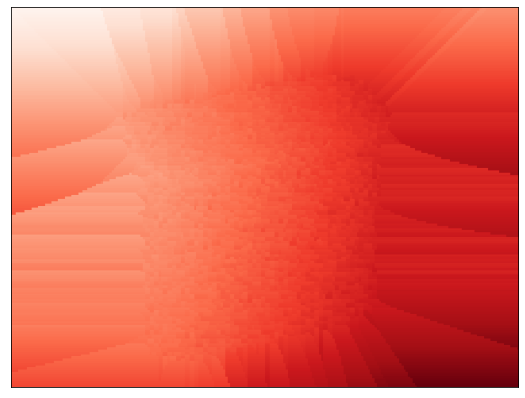

20 tensor([[[[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025],
          [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025],
          [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025],
          [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025],
          [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
           0.0025, 0.0025, 0.0025, 0.0025],
          [0.0025, 0.0025, 

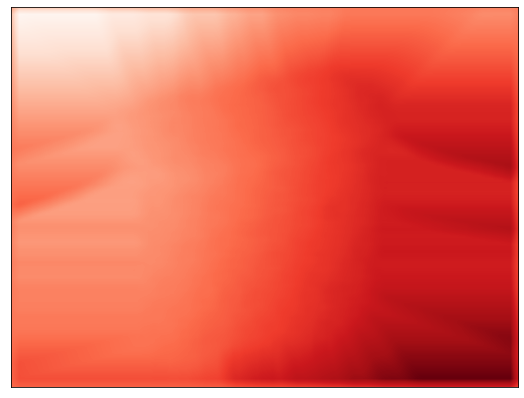

In [60]:
Drawer().disp_img_1d(u_map[0].numpy())
u_out = smooth(u_map[:,None,:,:],size=20)
Drawer().disp_img_1d(u_out[0,0].numpy())


In [ ]:
print("MEAN:\n", df.mean() )
print("\n \nSTD:\n", df.std() )
print("\n \nMAX:\n", df.max())
print("\n \nIDXMAX:\n", df.idxmax())

idxmax = df.idxmax()[0]
print(f'\n \nWorst Sample Index is {idxmax}')

In [68]:
from visu import plot_two_pcd
import pandas as pd
from deep_im import flow_to_trafo_PnP
modes = ['refine',"iterative1000","iterative100", "iterative100reER1","SOLVEPNP_EPNP"]
modes = ['SOLVEPNP_EPNP']
st = time.time()
for m in modes:
    device = 'cpu'
    full_time_in_ransac_ls = [0]
    visualizer = Visualizer('/home/jonfrey/Debug', None)

    K_ren = torch.tensor( dataset_train._backend.get_camera('data_syn/0019', K=True), device=device ) 
    K_ren = torch.tensor( dataset_train._backend.get_camera('data/0049', K=True), device=device ) 

    max_iter = 1000
    names = ["ID"]
    for lvl in range(0,30,3):
        names.append(f'adds_noise_std_{lvl}')
        names.append(f'l2_loss_scaled_{lvl}')
        names.append(f'l2_loss_orig_{lvl}')
    df = pd.DataFrame(columns=names)
   
    for j,batch in enumerate(dataloader_test):
        batch = batch[0]
        if j > max_iter-1:
            break
        if j % 5 == 0:
            print(f"Processed {j}/{max_iter} , Time: {time.time()-st}s")

        b = 0    
        model_points = batch[4]
        idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
        label = batch[7]
        real_img_original = batch[8]
        cam = batch[9]
        gt_rot_wxyz, gt_trans, unique_desig = batch[10:13] # unique_desig[1] contains the idx starting at 1 for the first object 
        bs = model_points.shape[0]
        if batch[13] is False:
            print('Continue')
            continue
        real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
        pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
        u_map, v_map, flow_mask, bb, depth_render_original= batch[24:]
        real_tl, real_br, ren_tl, ren_br = bb 

        data = torch.cat([real_img, render_img], dim=1)
        uv_gt = torch.stack( [u_map, v_map], dim=3 ).permute(0,3,1,2)

        K_real = torch.tensor( [[cam[b,2],0,cam[b,0]],[b,cam[b,3],cam[b,1]],[0,0,1]], device=device )

        #get inital estimate of the poistion given by the dataloader
        h_real_est = torch.eye(4,device=device)
        h_real_est[:3,:3] = quat_to_rot(pred_rot_wxyz[b][None,:], conv='wxyz', device=device)
        h_real_est[:3,3] = torch.tensor( pred_trans[b].clone().detach() ,device=device )
        
        p = model_points.shape[1]
        target = torch.bmm( model_points, torch.transpose(h_real[:,:3,:3], 1,2 ) ) + h_real[:,:3,3][:,None,:].repeat(1,p,1)

        ### GT Estimate ###
        typ = u_map.dtype
        fmt = flow_mask.dtype
        suc = True
        ### GT Label PnP ###
        dict_res = {}
        
        ### N1 ###
        w_bb = real_tl[b][1]-real_br[b][1] 
        
        uv_gt = torch.stack( [u_map, v_map], dim=1)
        for lvl in range(0,30,3):
            noise_org = -lvl * (float(w_bb)/640)
            n1 = float(np.random.normal(loc=0.0, scale=lvl))
            n2 = float(np.random.normal(loc=0.0, scale=lvl))
            u_map_clone = (u_map[b]).type( typ ).clone() + (n1)
            v_map_clone = (v_map[b]).type( typ ).clone() + (n2)
            
            
            
            ind = (flow_mask == True )[:,None,:,:].repeat(1,2,1,1)
            
            flow = torch.stack( [u_map_clone[None], v_map_clone[None]], dim=1)
            flow_loss_l2 = torch.sum( torch.norm( flow[:,:2,:,:] * ind  - uv_gt * ind, p=2, dim=1 ), dim=(1,2)) / torch.sum( ind[:,0,:,:], (1,2))
            
            suc_, n1_h_est = flow_to_trafo_PnP( 
                    real_br = real_br[b], 
                    real_tl = real_tl[b], 
                    ren_br = ren_br[b], 
                    ren_tl = ren_tl[b], 
                    flow_mask = (flow_mask[b]).clone(), 
                    u_map = u_map_clone, 
                    v_map = v_map_clone, 
                    K_ren = K_ren.type( typ ), 
                    K_real = K_real.type( typ ), 
                    render_d =  (render_d[b].type( typ )).clone(), 
                    h_render =(h_render[b].type( typ )).clone(),
                    h_real_est = h_real_est.type( typ ).clone())
            if suc_ == False:
                adds_res_n1 = 999
            else:
                adds_res_n1 = float(criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = n1_h_est[None].type( target.dtype) ).detach())
            dict_res[f'l2_loss_scaled_{lvl}'] = float( flow_loss_l2  )
            dict_res[f'l2_loss_orig_{lvl}'] = float( flow_loss_l2  ) * (float(w_bb)/640)
            dict_res[f'adds_noise_std_{lvl}'] = adds_res_n1
        dict_res["ID"] = int(unique_desig[1])
        df = df.append(dict_res, ignore_index=True)
        
    
    print('Resutls',str('  '+m+'  ')*10)
    print('Full time in ransac', full_time_in_ransac_ls)
    print( df.groupby(['ID']).mean() ) 
    print('END',str('  '+m+'  ')*10)
print("Finished")



/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Processed 0/1000 , Time: 0.7387003898620605s


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: 

In [105]:
#df.to_pickle("./gaus_filter_noise.pkl")

In [88]:
from visu import plot_two_pcd
import pandas as pd
from deep_im import flow_to_trafo_PnP
modes = ['SOLVEPNP_EPNP']
st = time.time()
for m in modes:
    device = 'cpu'
    full_time_in_ransac_ls = [0]
    visualizer = Visualizer('/home/jonfrey/Debug', None)

    K_ren = torch.tensor( dataset_train._backend.get_camera('data_syn/0019', K=True), device=device ) 
    K_ren = torch.tensor( dataset_train._backend.get_camera('data/0049', K=True), device=device ) 

    max_iter = 1000
    names = ["ID"]
    for lvl in range(0,50,10):
        names.append(f'adds_gaus_std_{lvl}')
        names.append(f'l2_loss_scaled_{lvl}')
        names.append(f'l2_loss_orig_{lvl}')
        
    df = pd.DataFrame(columns=names)
   
    for j,batch in enumerate(dataloader_test):
        batch = batch[0]
        if j > max_iter-1:
            break
        if j % 5 == 0:
            print(f"Processed {j}/{max_iter} , Time: {time.time()-st}s")

        b = 0    
        model_points = batch[4]
        idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
        label = batch[7]
        real_img_original = batch[8]
        cam = batch[9]
        gt_rot_wxyz, gt_trans, unique_desig = batch[10:13] # unique_desig[1] contains the idx starting at 1 for the first object 
        bs = model_points.shape[0]
        if batch[13] is False:
            print('Continue')
            continue
        real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
        pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
        u_map, v_map, flow_mask, bb, depth_render_original= batch[24:]
        real_tl, real_br, ren_tl, ren_br = bb 

        data = torch.cat([real_img, render_img], dim=1)
        uv_gt = torch.stack( [u_map, v_map], dim=3 ).permute(0,3,1,2)

        K_real = torch.tensor( [[cam[b,2],0,cam[b,0]],[b,cam[b,3],cam[b,1]],[0,0,1]], device=device )

        #get inital estimate of the poistion given by the dataloader
        h_real_est = torch.eye(4,device=device)
        h_real_est[:3,:3] = quat_to_rot(pred_rot_wxyz[b][None,:], conv='wxyz', device=device)
        h_real_est[:3,3] = torch.tensor( pred_trans[b].clone().detach() ,device=device )
        
        p = model_points.shape[1]
        target = torch.bmm( model_points, torch.transpose(h_real[:,:3,:3], 1,2 ) ) + h_real[:,:3,3][:,None,:].repeat(1,p,1)

        ### GT Estimate ###
        typ = u_map.dtype
        fmt = flow_mask.dtype
        suc = True
        ### GT Label PnP ###
        dict_res = {}
        
        ### N1 ###
        w_bb = real_tl[b][1]-real_br[b][1] 
        
        uv_gt = torch.stack( [u_map, v_map], dim=1)
        for lvl in range(0,50,10):
            #Drawer().disp_img_1d(u_map[0].numpy())
            
            inp = u_map[0].type( torch.float32).clone()[None,None,:,:]   
            u_map_clone = smooth(inp, size=lvl)[0][0]
            inp = v_map[0].type( torch.float32 ).clone()[None,None,:,:] 
            v_map_clone = smooth(inp,size=lvl)[0][0]
            
            #Drawer().disp_img_1d(u_map_clone.numpy())
            
            ind = (flow_mask == True )[:,None,:,:].repeat(1,2,1,1)
            
            flow = torch.stack( [u_map_clone[None], v_map_clone[None]], dim=1)
            flow_loss_l2 = torch.sum( torch.norm( flow[:,:2,:,:] * ind  - uv_gt * ind, p=2, dim=1 ), dim=(1,2)) / torch.sum( ind[:,0,:,:], (1,2))
            
            suc_, n1_h_est = flow_to_trafo_PnP( 
                    real_br = real_br[b], 
                    real_tl = real_tl[b], 
                    ren_br = ren_br[b], 
                    ren_tl = ren_tl[b], 
                    flow_mask = (flow_mask[b]).clone(), 
                    u_map = u_map_clone, 
                    v_map = v_map_clone, 
                    K_ren = K_ren.type( typ ), 
                    K_real = K_real.type( typ ), 
                    render_d =  (render_d[b].type( typ )).clone(), 
                    h_render =(h_render[b].type( typ )).clone(),
                    h_real_est = h_real_est.type( typ ).clone())
            if suc_ == False:
                adds_res_n1 = 999
            else:
                adds_res_n1 = float(criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = n1_h_est[None].type( target.dtype) ).detach())
            dict_res[f'l2_loss_scaled_{lvl}'] = float( flow_loss_l2  )
            dict_res[f'l2_loss_orig_{lvl}'] = -float( flow_loss_l2  ) * (float(w_bb)/640)
            dict_res[f'adds_gaus_std_{lvl}'] = adds_res_n1
        dict_res["ID"] = int(unique_desig[1])
        df = df.append(dict_res, ignore_index=True)
        
    
    print('Resutls',str('  '+m+'  ')*10)
    print('Full time in ransac', full_time_in_ransac_ls)
    print( df.groupby(['ID']).mean() ) 
    print('END',str('  '+m+'  ')*10)
print("Finished")



/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Processed 0/1000 , Time: 0.7510652542114258s


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Processed 5/1000 , Time: 4.458744764328003s
Processed 10/1000 , Time: 10.594762086868286s
Processed 15/1000 , Time: 14.51051139831543s
Processed 20/1000 , Time: 26.996370553970337s
Processed 25/1000 , Time: 33.657984018325806s
Processed 30/1000 , Time: 40.8067901134491s
Processed 35/1000 , Time: 50.05065870285034s
Processed 40/1000 , Time: 53.89304184913635s
Processed 45/1000 , Time: 60.72383642196655s
Processed 50/1000 , Time: 64.38445281982422s
Processed 55/1000 , Time: 68.34570550918579s
Processed 60/1000 , Time: 72.17752766609192s
Processed 65/1000 , Time: 75.26092648506165s
Processed 70/1000 , Time: 79.36172676086426s
Processed 75/1000 , Time: 88.4434666633606s
Processed 80/1000 , Time: 98.1508378982544s
Processed 85/1000 , Time: 103.73100733757019s
Processed 90/1000 , Time: 110.11983060836792s
Processed 95/1000 , Time: 116.09020948410034s
Processed 100/1000 , Time: 119.48330616950989s
Processed 105/1000 , Time: 129.86349964141846s
Processed 110/1000 , Time: 136.20813512802124s
Pr

Processed 895/1000 , Time: 1154.1282732486725s
Processed 900/1000 , Time: 1158.106693983078s
Processed 905/1000 , Time: 1164.6897177696228s
Processed 910/1000 , Time: 1168.6967811584473s
Processed 915/1000 , Time: 1178.9426755905151s
Processed 920/1000 , Time: 1182.7104511260986s
Processed 925/1000 , Time: 1189.7258682250977s
Processed 930/1000 , Time: 1196.4006979465485s
Processed 935/1000 , Time: 1206.4179365634918s
Processed 940/1000 , Time: 1209.7814342975616s
Processed 945/1000 , Time: 1213.9392304420471s
Processed 950/1000 , Time: 1223.8082988262177s
Processed 955/1000 , Time: 1233.6708517074585s
Processed 960/1000 , Time: 1244.2529139518738s
Processed 965/1000 , Time: 1254.8596832752228s
Processed 970/1000 , Time: 1261.5907528400421s
Processed 975/1000 , Time: 1265.4906759262085s
Processed 980/1000 , Time: 1273.2708580493927s
Processed 985/1000 , Time: 1279.853086233139s
Processed 990/1000 , Time: 1283.8013434410095s
Processed 995/1000 , Time: 1291.0417830944061s
Resutls   SOLVE

,ID,adds_gaus_std_0,l2_loss_scaled_0,l2_loss_orig_0,adds_gaus_std_10,l2_loss_scaled_10,l2_loss_orig_10,adds_gaus_std_20,l2_loss_scaled_20,l2_loss_orig_20,adds_gaus_std_30,l2_loss_scaled_30,l2_loss_orig_30,adds_gaus_std_40,l2_loss_scaled_40,l2_loss_orig_40
0,6.0,0.000963,0.0,0.0,0.002167,3.726944,0.890973,0.002858,4.955729,1.184729,0.003536,5.331488,1.274559,0.004252,5.447970,1.302405
1,12.0,0.001115,0.0,0.0,0.016595,2.285025,1.310319,0.026318,3.012444,1.727448,0.036023,3.662944,2.100469,0.045402,4.430069,2.540368
2,9.0,0.001422,0.0,0.0,0.001438,3.001177,0.839392,0.001694,3.730938,1.043497,0.002147,4.106887,1.148645,0.002681,4.434209,1.240193
3,2.0,0.001609,0.0,0.0,0.001156,1.837490,1.108236,0.001718,2.366030,1.427012,0.002243,2.822848,1.702530,0.002985,3.379699,2.038381
4,18.0,0.001070,0.0,0.0,0.005540,5.897935,1.354682,0.007738,8.538484,1.961183,0.006899,10.787030,2.477646,0.009766,12.546469,2.881767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.0,0.001754,0.0,0.0,0.002338,3.140890,1.207280,0.003107,3.933154,1.511806,0.004287,4.492617,1.726850,0.006000,5.136844,1.974474
996,4.0,0.005199,0.0,0.0,0.084773,4.214149,1.540798,0.098063,5.496332,2.009596,0.108477,6.535616,2.389585,0.118292,7.526185,2.751761
997,6.0,0.002975,0.0,0.0,0.005727,3.772015,0.654209,0.005995,5.538054,0.960506,0.005871,6.701848,1.162352,0.006678,7.336814,1.272479
998,1.0,0.001046,0.0,0.0,0.001253,2.387326,1.137710,0.001583,2.613950,1.245710,0.002277,2.701591,1.287477,0.003589,2.792659,1.330876


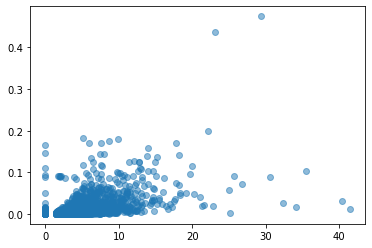

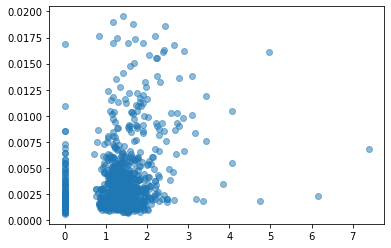

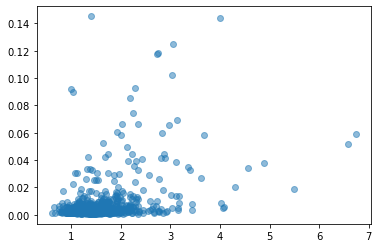

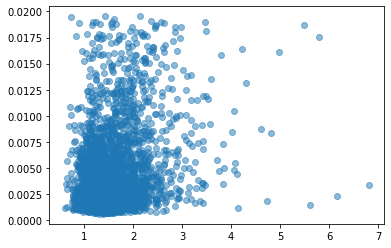

In [117]:
#df = pd.read_pickle("gaus_filter_noise.pkl")
import numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

l2s_ls = []
l2o_ls = []
adds_ls =[]
idx_ls =[]
idx = 3
for idx in range(0,50,10):
    ids = df[f'ID']
    adds = df[f'adds_gaus_std_{idx}']
    l2s = df[f'l2_loss_scaled_{idx}']
    l2o = df[f'l2_loss_orig_{idx}']
    adds_ls.append(adds)
    l2s_ls.append(l2s)
    l2o_ls.append(l2o)


adds_all = np.array( adds_ls ).flatten()
l2s_all = np.array( l2s_ls ).flatten()
l2o_all = np.array( l2o_ls ).flatten()


# plt.scatter(l2s, adds, alpha=0.5)
# plt.show()

# plt.scatter(l2o, adds, alpha=0.5)
# plt.show()

plt.scatter(l2s_all, adds_all, alpha=0.5)
plt.show()



m1 = adds_all<0.02
plt.scatter(l2o_all[m1][::5], adds_all[m1][::5], alpha=0.5)
plt.show()

m = (l2o_all>0.5 )*(l2o_all<7)
plt.scatter(l2o_all[m][::5], adds_all[m][::5], alpha=0.5)
plt.show()


m2  = m * m1
plt.scatter(l2o_all[m2][::1], adds_all[m2][::1], alpha=0.5)
plt.show()


bins = numpy.linspace(0, 20, 11)
digitized = numpy.digitize(l2o_all[m2], bins)

# plt.clf()
# sns.jointplot(l2o_all[m2], adds_all[m2], kind = 'kde')
# plt.gcf().suptitle('Density of Features')
# plt.tight_layout()
# plt.show()

bin 1 elements 288
bin 2 elements 431
bin 3 elements 458
bin 4 elements 435
bin 5 elements 356
bin 6 elements 297
bin 7 elements 224
bin 8 elements 192
bin 9 elements 136
bin 10 elements 136
bin 11 elements 72
bin 12 elements 86
bin 13 elements 49
bin 14 elements 33
bin 15 elements 27
bin 16 elements 28
bin 17 elements 14
bin 18 elements 15
bin 19 elements 15


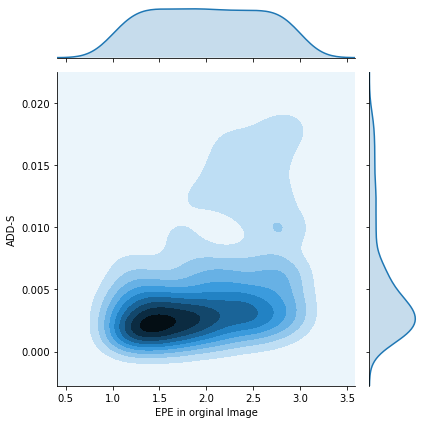

bin 1 elements 16
bin 2 elements 402
bin 3 elements 535
bin 4 elements 596
bin 5 elements 558
bin 6 elements 409
bin 7 elements 289
bin 8 elements 203
bin 9 elements 171
bin 10 elements 114
(160,) (160,)


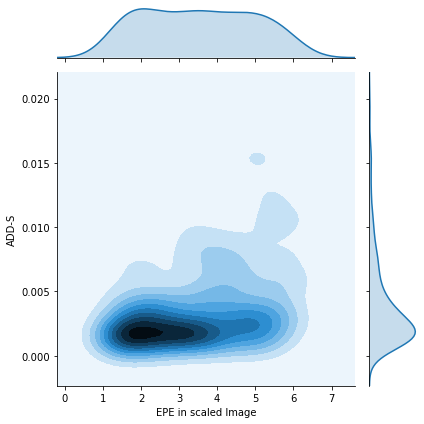

In [128]:
import numpy
bins = numpy.linspace(1, 3, 20)
data = l2o_all[m2]
data2 = adds_all[m2]

digitized = numpy.digitize(data, bins)
minx = 999
for i in range(1, len(bins)):
    if data[digitized == i].shape[0] < minx:
        minx = data[digitized == i].shape[0]
add = []
l2 = []
for i in range(1, len(bins)):
    tmp = data[digitized == i]
    idx = np.arange(0,int(tmp.shape[0]),1)
    np.random.shuffle(idx)
    print(f"bin {i} elements {int(tmp.shape[0])}")
    idx = idx[:minx]
    add.append( data2[digitized == i][idx] )
    l2.append( data[digitized == i][idx] )

add = np.array(add).flatten()
l2 = np.array(l2).flatten()  

sns.jointplot(l2, add, kind = 'kde')
#plt.gcf().suptitle('ADD-S to EPE')
plt.gcf().axes[0].set_xlabel('EPE in orginal Image')
plt.gcf().axes[0].set_ylabel('ADD-S')
plt.tight_layout()
plt.savefig("/home/jonfrey/PLR3/submisson/adds-to-epe-gaus--40.png",dpi=600)
plt.show()


import numpy
nr = 10
bins = numpy.linspace(1, 6, nr+1)
data = l2s_all[m2]
data2 = adds_all[m2]
digitized = numpy.digitize(data, bins)
minx = 999
for i in range(1, len(bins)):
    if data[digitized == i].shape[0] < minx:
        minx = data[digitized == i].shape[0]
add = []
l2 = []
for i in range(1, len(bins)):
    tmp = data[digitized == i]
    idx = np.arange(0,int(tmp.shape[0]),1)
    np.random.shuffle(idx)
    print(f"bin {i} elements {int(tmp.shape[0])}")
    idx = idx[:minx]
    add.append( data2[digitized == i][idx] )
    l2.append( data[digitized == i][idx] )

add = np.array(add).flatten()
l2 = np.array(l2).flatten()  
print(l2.shape, add.shape)
sns.jointplot(l2, add, kind = 'kde')#,height=4)
plt.gcf().axes[0].set_xlabel('EPE in scaled Image')
plt.gcf().axes[0].set_ylabel('ADD-S')
plt.tight_layout()
plt.savefig("/home/jonfrey/PLR3/submisson/adds-to-epe-in-scaled-gaus.png",dpi=600)
plt.show()

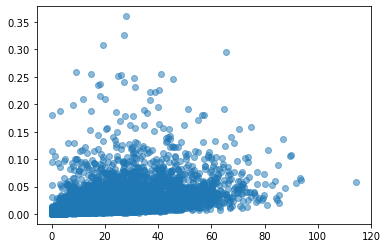

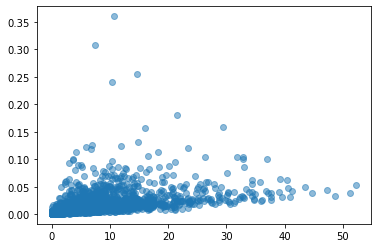

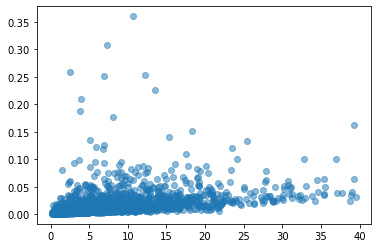

[ 1  1  1 ...  4 11  2]


<Figure size 432x288 with 0 Axes>

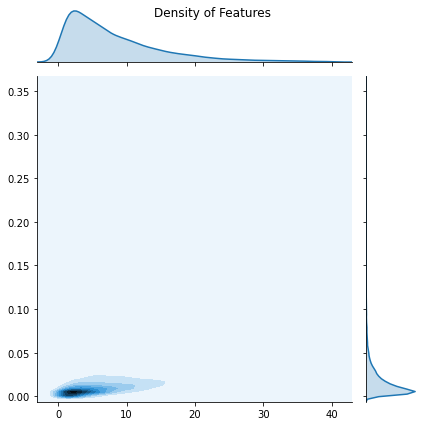

In [130]:
# plot for noise

df = pd.read_pickle("./offset_noise.pkl")
l2s_ls = []
l2o_ls = []
adds_ls =[]
idx_ls =[]
idx = 3
for idx in range(0,30,3):
    ids = df[f'ID']
    adds = df[f'adds_noise_std_{idx}']
    l2s = df[f'l2_loss_scaled_{idx}']
    l2o = -df[f'l2_loss_orig_{idx}']
    ids = df[f'adds_noise_std_{idx}']
    adds_ls.append(adds)
    l2s_ls.append(l2s)
    l2o_ls.append(l2o)
    idx_ls.append(ids)

import numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
adds_all = np.array( adds_ls ).flatten()
l2s_all = np.array( l2s_ls ).flatten()
l2o_all = np.array( l2o_ls ).flatten()


# plt.scatter(l2s, adds, alpha=0.5)
# plt.show()

# plt.scatter(l2o, adds, alpha=0.5)
# plt.show()

plt.scatter(l2s_all, adds_all, alpha=0.5)
plt.show()



m1 = adds_all<1
plt.scatter(l2o_all[m1][::5], adds_all[m1][::5], alpha=0.5)
plt.show()

m = (l2o_all>0 )*(l2o_all<40)
plt.scatter(l2o_all[m][::5], adds_all[m][::5], alpha=0.5)
plt.show()

plt.clf()


m2  = m * m1


bins = numpy.linspace(0, 20, 11)
digitized = numpy.digitize(l2o_all[m2], bins)
print(digitized)

sns.jointplot(l2o_all[m2], adds_all[m2], kind = 'kde')
plt.gcf().suptitle('Density of Features')
plt.tight_layout()
plt.show()

In [156]:

#print( df['ID'].value_counts() )
# print( df_failed['ID_Failed'].value_counts())
df.groupby(['ID']).mean()

df_start = df["adds_noise_std_0"] 
df_id = df[ "ID" ]
for i in range(3,30,3):
    df_start = df_start.append( df[f"adds_noise_std_{i}"] )
    df_id = df_id.append(df["ID"])

df_new = pd.concat( [df_start, df_id], axis=1)
df_new

df_new.groupby(['ID']).mean()

#pd.concat([s1, s2], axis=1)

,0
ID,
1.0,0.018013
2.0,0.019093
3.0,0.017882
4.0,0.020254
5.0,0.020641
6.0,0.012582
7.0,0.013173
8.0,0.009514
9.0,0.022900


bin 1 elements 215
bin 2 elements 553
bin 3 elements 587
bin 4 elements 537
bin 5 elements 510
bin 6 elements 477
bin 7 elements 429
bin 8 elements 393
bin 9 elements 395
bin 10 elements 355
bin 11 elements 327
bin 12 elements 282
bin 13 elements 258
bin 14 elements 228
bin 15 elements 228
bin 16 elements 221
bin 17 elements 195
bin 18 elements 179
bin 19 elements 166
bin 20 elements 143
bin 21 elements 144
bin 22 elements 119
bin 23 elements 123
bin 24 elements 108
bin 25 elements 107
bin 26 elements 79
bin 27 elements 90
bin 28 elements 81
bin 29 elements 69
bin 30 elements 58
bin 31 elements 54
bin 32 elements 48
bin 33 elements 62
bin 34 elements 46
bin 35 elements 31
bin 36 elements 36
bin 37 elements 35
bin 38 elements 30
bin 39 elements 24
bin 40 elements 17


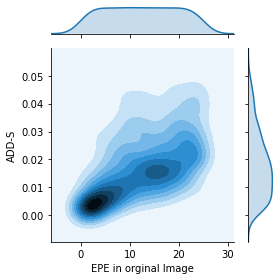

In [50]:
import numpy
bins = numpy.linspace(0, 25, 41)
data = l2o_all[m2]
data2 = adds_all[m2]

digitized = numpy.digitize(data, bins)
minx = 999
for i in range(1, len(bins)):
    if data[digitized == i].shape[0] < minx:
        minx = data[digitized == i].shape[0]
add = []
l2 = []
for i in range(1, len(bins)):
    tmp = data[digitized == i]
    idx = np.arange(0,int(tmp.shape[0]),1)
    np.random.shuffle(idx)
    print(f"bin {i} elements {int(tmp.shape[0])}")
    idx = idx[:minx]
    add.append( data2[digitized == i][idx] )
    l2.append( data[digitized == i][idx] )

add = np.array(add).flatten()
l2 = np.array(l2).flatten()  

sns.jointplot(l2, add, kind = 'kde',height=4)
#plt.gcf().suptitle('ADD-S to EPE')
plt.gcf().axes[0].set_xlabel('EPE in orginal Image')
plt.gcf().axes[0].set_ylabel('ADD-S')
plt.tight_layout()
#plt.savefig("/home/jonfrey/PLR3/submisson/adds-to-epe-h4-40.png",dpi=600)
plt.show()

bin 1 elements 77
bin 2 elements 242
bin 3 elements 369
bin 4 elements 360
bin 5 elements 361
bin 6 elements 387
bin 7 elements 353
bin 8 elements 360
bin 9 elements 296
bin 10 elements 307
bin 11 elements 254
bin 12 elements 289
bin 13 elements 256
bin 14 elements 241
bin 15 elements 210
bin 16 elements 253
bin 17 elements 211
bin 18 elements 211
bin 19 elements 220
bin 20 elements 209
bin 21 elements 196
bin 22 elements 184
bin 23 elements 149
bin 24 elements 153
bin 25 elements 158
bin 26 elements 140
bin 27 elements 130
bin 28 elements 132
bin 29 elements 113
bin 30 elements 108
bin 31 elements 106
bin 32 elements 93
bin 33 elements 91
bin 34 elements 87
bin 35 elements 83
bin 36 elements 75
bin 37 elements 58
bin 38 elements 50
bin 39 elements 50
bin 40 elements 44
(1760,) (1760,)


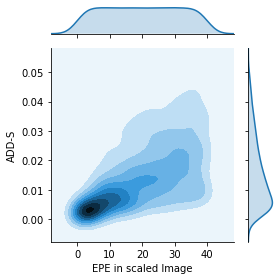

In [51]:
import numpy
nr = 40
bins = numpy.linspace(0, nr, nr+1)
data = l2s_all[m2]
data2 = adds_all[m2]
digitized = numpy.digitize(data, bins)
minx = 999
for i in range(1, len(bins)):
    if data[digitized == i].shape[0] < minx:
        minx = data[digitized == i].shape[0]
add = []
l2 = []
for i in range(1, len(bins)):
    tmp = data[digitized == i]
    idx = np.arange(0,int(tmp.shape[0]),1)
    np.random.shuffle(idx)
    print(f"bin {i} elements {int(tmp.shape[0])}")
    idx = idx[:minx]
    add.append( data2[digitized == i][idx] )
    l2.append( data[digitized == i][idx] )

add = np.array(add).flatten()
l2 = np.array(l2).flatten()  
print(l2.shape, add.shape)
sns.jointplot(l2, add, kind = 'kde',height=4)
plt.gcf().axes[0].set_xlabel('EPE in scaled Image')
plt.gcf().axes[0].set_ylabel('ADD-S')
plt.tight_layout()
plt.savefig("/home/jonfrey/PLR3/submisson/adds-to-epe-in-scaled-h4.png",dpi=600)
plt.show()

In [ ]:
print("test")